In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split

class ConvMLPDAE_32x32(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: down to (B, 64, 4, 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # → (B, 16, 16, 16)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # → (B, 32, 8, 8)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # → (B, 64, 4, 4)
            nn.ReLU()
        )

        # MLP bottleneck: 64×4×4 = 1024
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU()
        )
        self.unflatten = nn.Unflatten(1, (64, 4, 4))

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # (B, 1, 32, 32)
            nn.Tanh()  # if Wigner is [-1, 1]; use Sigmoid if [0, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.flatten(z)
        z = self.mlp(z)
        z = self.unflatten(z)
        return self.decoder(z)


In [ ]:

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))


def add_2d_positional_encoding(x):
    B, C, H, W = x.shape
    device = x.device

    y_pos = torch.linspace(-1, 1, H, device=device).view(1, 1, H, 1).expand(B, 1, H, W)
    x_pos = torch.linspace(-1, 1, W, device=device).view(1, 1, 1, W).expand(B, 1, H, W)
    
    return torch.cat([x, x_pos, y_pos], dim=1)  # Add 2 channels


class ConvResMLPDAE_32x32(nn.Module):
    def __init__(self):
        super().__init__()

        # Positional encoding → add 2 channels
        self.input_proj = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)  # (B, 3, 32, 32) → (B, 16, 16, 16)

        self.encoder = nn.Sequential(
            ResBlock(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # → (B, 32, 8, 8)
            nn.ReLU(),
            ResBlock(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # → (B, 64, 4, 4)
            nn.ReLU(),
            ResBlock(64)
        )

        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * 4 * 4),
            nn.ReLU()
        )
        self.unflatten = nn.Unflatten(1, (64, 4, 4))

        self.decoder = nn.Sequential(
            ResBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 8, 8)
            nn.ReLU(),
            ResBlock(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 16, 16)
            nn.ReLU(),
            ResBlock(16),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # (B, 1, 32, 32)
            nn.Tanh()
        )

    def forward(self, x):
        x = add_2d_positional_encoding(x)  # (B, 1, 32, 32) → (B, 3, 32, 32)
        x = self.input_proj(x)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.mlp(x)
        x = self.unflatten(x)
        return self.decoder(x)


In [66]:
class WignerNPZDataset(Dataset):
    def __init__(self, folder_path, normalize=True):
        self.folder_path = folder_path
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".npz")])
        self.normalize = normalize

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.folder_path, self.files[idx])
        data = np.load(path)
        noisy = data["noisy"].astype(np.float32)
        clean = data["clean"].astype(np.float32)

        # Resize or crop here if needed
        if self.normalize:
            noisy = np.clip(noisy, -1.0, 1.0)
            clean = np.clip(clean, -1.0, 1.0)

        # Add channel dimension for CNNs
        noisy = torch.tensor(noisy).unsqueeze(0)  # shape (1, H, W)
        clean = torch.tensor(clean).unsqueeze(0)

        return noisy, clean


In [9]:
dataset = WignerNPZDataset("wigner_dataset_32/")
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for batch_noisy, batch_clean in loader:
    print("Noisy batch:", batch_noisy.shape)  # (B, 1, H, W)
    print("Clean batch:", batch_clean.shape)
    break


Noisy batch: torch.Size([8, 1, 32, 32])
Clean batch: torch.Size([8, 1, 32, 32])


In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model + Loss + Optimizer
model = ConvResMLPDAE_32x32().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Load data
dataset = WignerNPZDataset("wigner_train_32/")
total_size = len(dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Train loop
n_epochs = 20
train_loss_history = []
val_loss_history = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for x_noisy, x_clean in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{n_epochs}"):
        x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)

        output = model(x_noisy)
        loss = criterion(output, x_clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_noisy, x_clean in val_loader:
            x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
            output = model(x_noisy)
            loss = criterion(output, x_clean)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")



[Train] Epoch 1/20: 100%|██████████| 500/500 [00:47<00:00, 10.62it/s]


[Epoch 1] Train Loss: 0.003410 | Val Loss: 0.001839


[Train] Epoch 2/20: 100%|██████████| 500/500 [00:29<00:00, 17.11it/s]


[Epoch 2] Train Loss: 0.001286 | Val Loss: 0.000719


[Train] Epoch 3/20: 100%|██████████| 500/500 [00:27<00:00, 18.38it/s]


[Epoch 3] Train Loss: 0.000608 | Val Loss: 0.000394


[Train] Epoch 4/20: 100%|██████████| 500/500 [00:27<00:00, 18.43it/s]


[Epoch 4] Train Loss: 0.000434 | Val Loss: 0.000348


[Train] Epoch 5/20: 100%|██████████| 500/500 [00:27<00:00, 18.37it/s]


[Epoch 5] Train Loss: 0.000356 | Val Loss: 0.000383


[Train] Epoch 6/20: 100%|██████████| 500/500 [00:27<00:00, 18.24it/s]


[Epoch 6] Train Loss: 0.000301 | Val Loss: 0.000334


[Train] Epoch 7/20: 100%|██████████| 500/500 [00:28<00:00, 17.77it/s]


[Epoch 7] Train Loss: 0.000355 | Val Loss: 0.000360


[Train] Epoch 8/20: 100%|██████████| 500/500 [00:28<00:00, 17.56it/s]


[Epoch 8] Train Loss: 0.000288 | Val Loss: 0.000261


[Train] Epoch 9/20: 100%|██████████| 500/500 [00:27<00:00, 18.37it/s]


[Epoch 9] Train Loss: 0.000285 | Val Loss: 0.000266


[Train] Epoch 10/20: 100%|██████████| 500/500 [00:27<00:00, 18.48it/s]


[Epoch 10] Train Loss: 0.000258 | Val Loss: 0.000258


[Train] Epoch 11/20: 100%|██████████| 500/500 [00:29<00:00, 17.17it/s]


[Epoch 11] Train Loss: 0.000258 | Val Loss: 0.000257


[Train] Epoch 12/20: 100%|██████████| 500/500 [00:59<00:00,  8.42it/s]


[Epoch 12] Train Loss: 0.000257 | Val Loss: 0.000286


[Train] Epoch 13/20: 100%|██████████| 500/500 [00:30<00:00, 16.54it/s]


[Epoch 13] Train Loss: 0.000228 | Val Loss: 0.000219


[Train] Epoch 14/20: 100%|██████████| 500/500 [00:28<00:00, 17.70it/s]


[Epoch 14] Train Loss: 0.000212 | Val Loss: 0.000216


[Train] Epoch 15/20: 100%|██████████| 500/500 [00:28<00:00, 17.47it/s]


[Epoch 15] Train Loss: 0.000205 | Val Loss: 0.000224


[Train] Epoch 16/20: 100%|██████████| 500/500 [00:25<00:00, 19.80it/s]


[Epoch 16] Train Loss: 0.000243 | Val Loss: 0.000387


[Train] Epoch 17/20: 100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


[Epoch 17] Train Loss: 0.000273 | Val Loss: 0.000222


[Train] Epoch 18/20: 100%|██████████| 500/500 [00:20<00:00, 23.97it/s]


[Epoch 18] Train Loss: 0.000244 | Val Loss: 0.000208


[Train] Epoch 19/20: 100%|██████████| 500/500 [00:20<00:00, 24.04it/s]


[Epoch 19] Train Loss: 0.000212 | Val Loss: 0.000214


[Train] Epoch 20/20: 100%|██████████| 500/500 [00:20<00:00, 24.04it/s]


[Epoch 20] Train Loss: 0.000208 | Val Loss: 0.000229


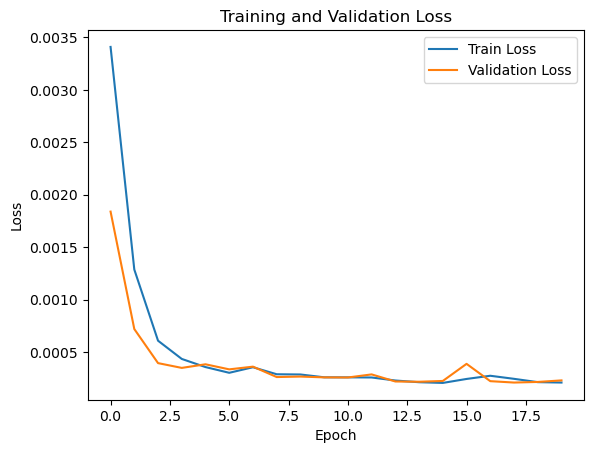

In [32]:
plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Save the model
torch.save(model.state_dict(), "conv_res_mlp_dae_32x32.pth")

# Save the plot
plt.savefig("loss_conv_res_mlp_dae_32x32.png")
plt.show()

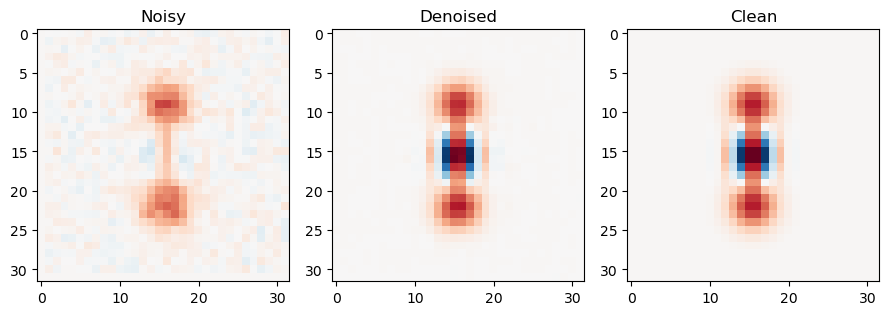

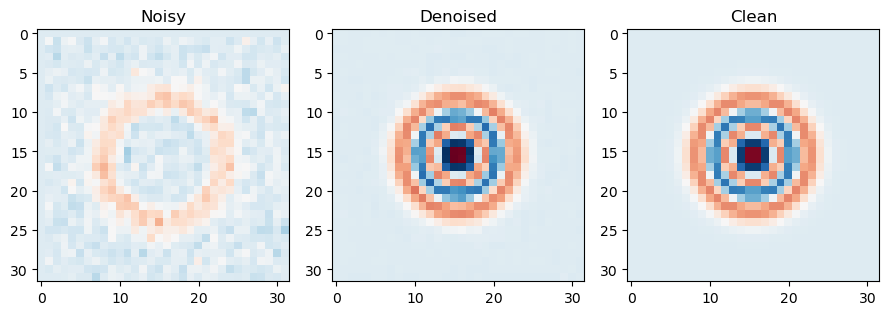

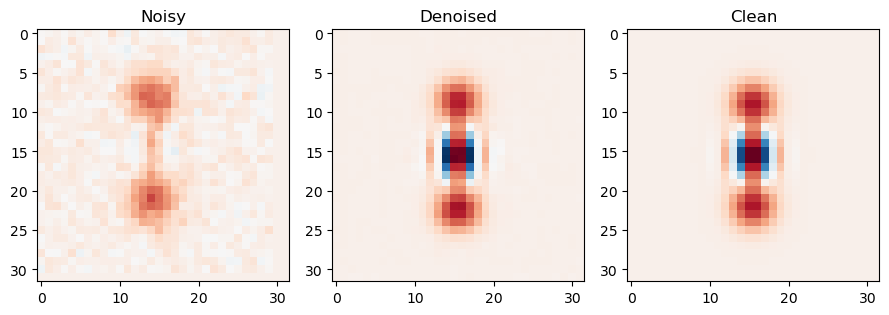

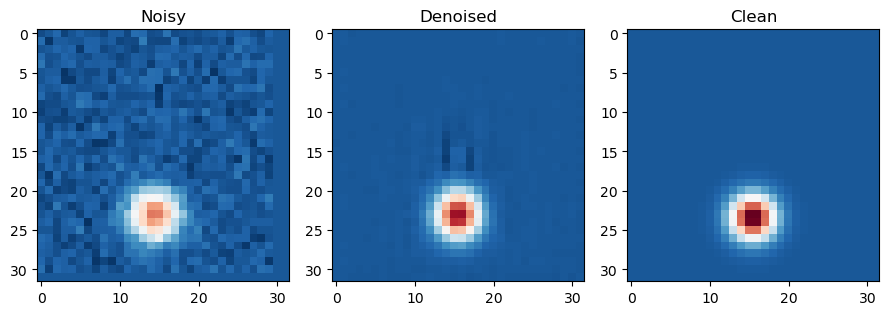

In [35]:
model.eval()

sample_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

with torch.no_grad():
    for x_noisy, x_clean in sample_loader:
        x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
        x_denoised = model(x_noisy)
        break  # only do one batch

# Plot results
for i in range(x_noisy.size(0)):
    n = x_noisy[i, 0].cpu()
    d = x_denoised[i, 0].cpu()
    c = x_clean[i, 0].cpu()

    vmin = min(n.min(), d.min(), c.min()).item()
    vmax = max(n.max(), d.max(), c.max()).item()

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    axs[0].imshow(n, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[0].set_title("Noisy")

    axs[1].imshow(d, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[1].set_title("Denoised")

    axs[2].imshow(c, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[2].set_title("Clean")

    plt.tight_layout()
    plt.show()


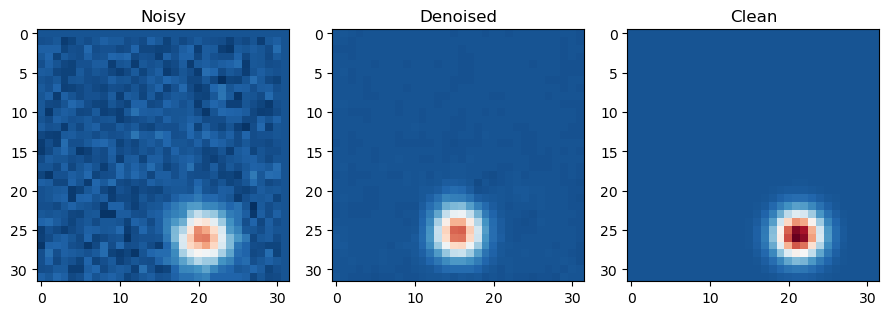

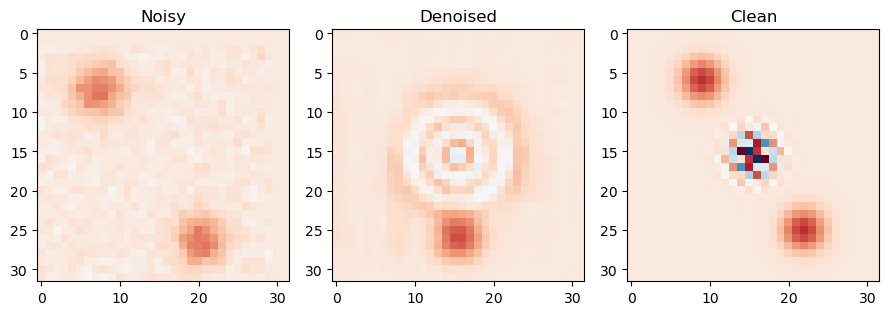

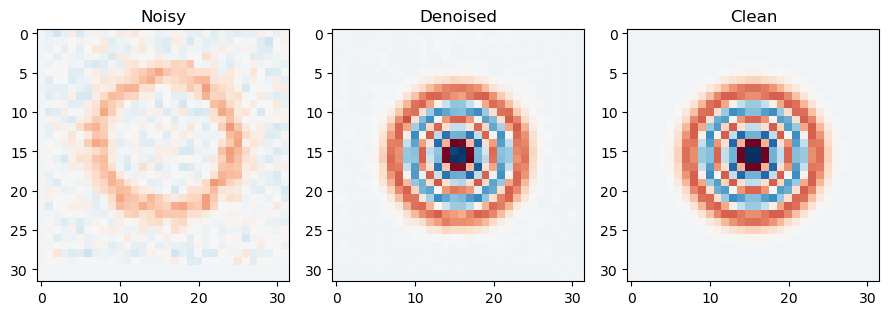

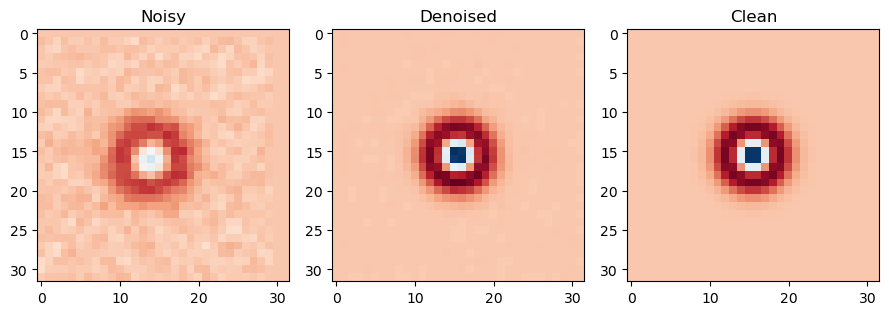

In [ ]:
test_dataset = WignerNPZDataset("wigner_test_32/")

model.eval()

sample_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

with torch.no_grad():
    for x_noisy, x_clean in sample_loader:
        x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
        x_denoised = model(x_noisy)
        break  # only do one batch

# Plot results
for i in range(x_noisy.size(0)):
    n = x_noisy[i, 0].cpu()
    d = x_denoised[i, 0].cpu()
    c = x_clean[i, 0].cpu()

    vmin = min(n.min(), d.min(), c.min()).item()
    vmax = max(n.max(), d.max(), c.max()).item()

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    axs[0].imshow(n, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[0].set_title("Noisy")

    axs[1].imshow(d, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[1].set_title("Denoised")

    axs[2].imshow(c, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[2].set_title("Clean")

    plt.tight_layout()
    plt.show()

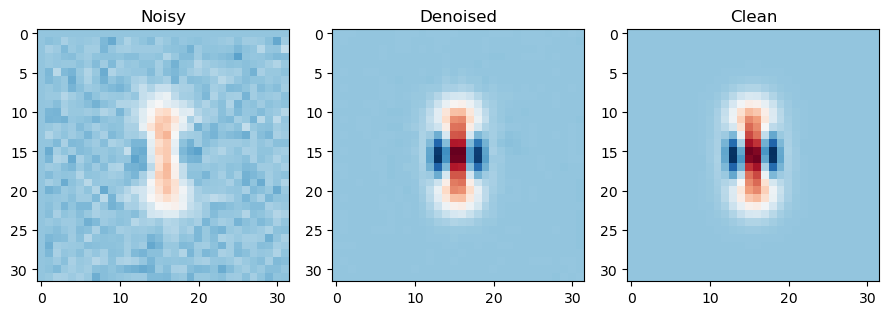

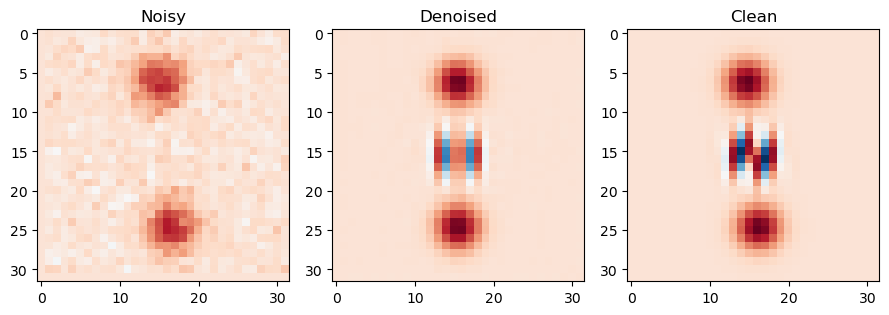

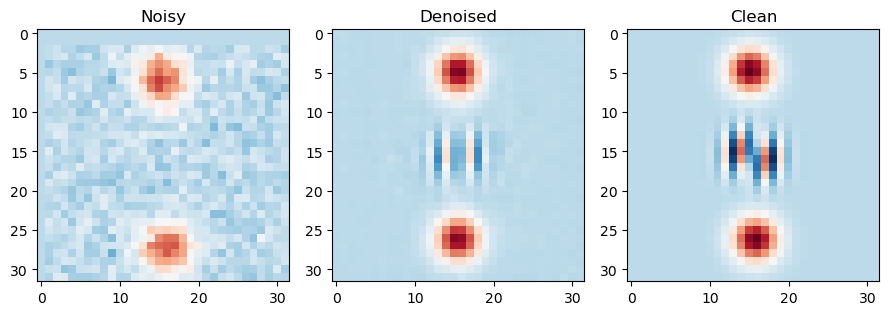

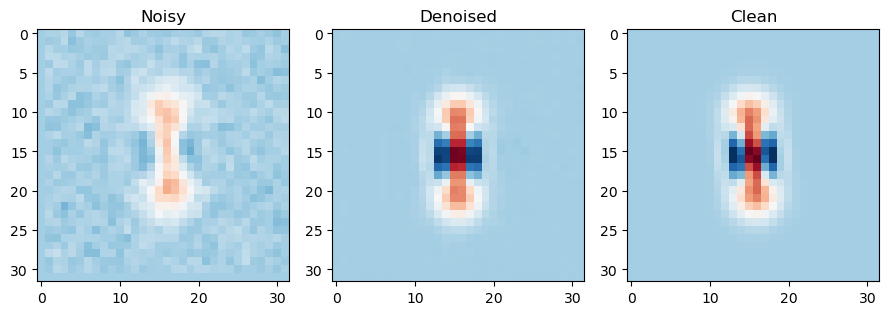

In [63]:
test_dataset = WignerNPZDataset("wigner_test3_32/", normalize=True)

model.eval()

sample_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

with torch.no_grad():
    for x_noisy, x_clean in sample_loader:
        x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
        x_denoised = model(x_noisy)
        break  # only do one batch

# Plot results
for i in range(x_noisy.size(0)):
    n = x_noisy[i, 0].cpu()
    d = x_denoised[i, 0].cpu()
    c = x_clean[i, 0].cpu()

    vmin = min(n.min(), d.min(), c.min()).item()
    vmax = max(n.max(), d.max(), c.max()).item()

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    axs[0].imshow(n, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[0].set_title("Noisy")

    axs[1].imshow(d, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[1].set_title("Denoised")

    axs[2].imshow(c, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    axs[2].set_title("Clean")

    plt.tight_layout()
    plt.show()

In [65]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for x_noisy, x_clean in test_loader:
        x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
        x_denoised = model(x_noisy)
        loss = criterion(x_denoised, x_clean)
        total_loss += loss.item()
        num_samples += 1

avg_mse = total_loss / (num_samples)  # normalize per pixel
print(f"Test MSE : {avg_mse:.6f}")

Test MSE : 0.000498
